In [1]:
# Импортируем необходимые библиотеки
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import nltk
from collections import Counter
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast

In [2]:
# Установим случайные начальные значения для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Проверим доступность GPU видеокарты
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [4]:
# 1. Предварительная обработка данных

class VideoDataset(Dataset):
    """Датасет для работы с видео и их описаниями"""
    
    def __init__(self, feature_dir, caption_file, vocab, max_frames=40):
        """Инициализация датасета
        
        Аргументы:
            feature_dir (str): Путь к директории с предвычисленными признаками
            caption_file (str): Файл с описаниями в формате "video_id описание"
            vocab (Vocabulary): Объект словаря для токенизации
            max_frames (int): Макс. количество кадров на видео
        """
        self.feature_dir = feature_dir
        self.max_frames = max_frames
        self.vocab = vocab
        
        # Загрузка и парсинг описаний
        self.captions = self._load_captions(caption_file)
        self.video_ids = list(self.captions.keys())
    
    def _load_captions(self, caption_file):
        """Загружает описания из файла"""
        captions = {}
        with open(caption_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    video_id, caption = parts
                    captions.setdefault(video_id, []).append(caption)
        return captions
    
    def __len__(self):
        return len(self.video_ids)
    
    def __getitem__(self, idx):
        """Получает один элемент датасета по индексу"""
        video_id = self.video_ids[idx]
        
        # Загрузка предвычисленных признаков
        features = self._load_features(video_id)
        
        # Выбор случайного описания и токенизация
        caption = self._process_caption(video_id)
        
        return features, caption
    
    def _load_features(self, video_id):
        """Загружает признаки видео из файла"""
        feature_path = os.path.join(self.feature_dir, f"{video_id}.npy")
        features = np.load(feature_path)
        
        # Проверяем и корректируем размерность
        if features.ndim > 2:            
            features = features.reshape(features.shape[0], -1) # Преобразуем к [seq_len, feature_dim]
        return torch.FloatTensor(features).to(device)
    
    def _process_caption(self, video_id):
        """Токенизирует и преобразует описание в тензор"""
        caption = np.random.choice(self.captions[video_id])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        return torch.LongTensor(caption)

class Vocabulary:
    """Словарь для преобразования слов в индексы"""
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self._add_special_tokens()
    
    def _add_special_tokens(self):
        """Добавляет специальные токены"""
        for token in ['<pad>', '<start>', '<end>', '<unk>']:
            self.add_word(token)
    
    def add_word(self, word):
        """Добавляет слово в словарь"""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__(self, word):
        """Возвращает индекс слова или токен <unk>"""
        return self.word2idx.get(word, self.word2idx['<unk>'])
    
    def __len__(self):
        return len(self.word2idx)

def build_vocab(caption_file, threshold=3):
    """Строит словарь на основе файла с описаниями"""
    counter = Counter()
    
    # Подсчет частот слов
    with open(caption_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                counter.update(nltk.tokenize.word_tokenize(parts[1].lower()))
    
    # Фильтрация по порогу
    vocab = Vocabulary()
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)
    
    return vocab

def precompute_features(video_dir, output_dir, batch_size=16):
    """Предварительно вычисляет признаки видео с помощью ResNet152"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Инициализация модели для извлечения признаков
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
    feature_extractor.eval()
    
    # Трансформации для кадров
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Обработка видеофайлов
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi'))]
    
    for i in range(0, len(video_files), batch_size):
        batch_files = video_files[i:i + batch_size]
        
        for video_file in tqdm(batch_files, desc=f"Batch {i//batch_size + 1}"):
            
            video_id = os.path.splitext(video_file)[0]
            feature_path = os.path.join(output_dir, f"{video_id}.npy") # Проверяем, существуют ли уже признаки
            if os.path.exists(feature_path):
                continue  # Признаки уже есть, пропускаем

            video_path = os.path.join(video_dir, video_file)
            # Извлечение кадров
            frames = extract_frames(video_path)
            
            # Извлечение признаков
            features = []
            with torch.no_grad():
                for frame in frames:
                    if frame.ndim == 3:  # Проверка валидности кадра
                        frame = transform(frame).unsqueeze(0).to(device)
                        feature = feature_extractor(frame).squeeze().cpu().numpy()
                        features.append(feature)
            
            # Сохранение признаков
            features = np.stack(features, axis=0)
            np.save(os.path.join(output_dir, f"{video_id}.npy"), features)

def extract_frames(video_path, max_frames=40):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sample_rate = max(1, frame_count // max_frames)
    frames = []
    
    for i in range(0, frame_count, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if len(frames) >= max_frames:
            break
    
    cap.release()
    
    # Если кадров меньше, чем нужно, дублируем последний кадр вместо нулей
    if len(frames) < max_frames and len(frames) > 0:
        last_frame = frames[-1]
        frames.extend([last_frame for _ in range(max_frames - len(frames))])
    elif len(frames) == 0:  # Если кадров нет вообще
        frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(max_frames)]
    
    return frames


In [5]:
# 2. Извлечение признаков

class FeatureExtractor:
    """
    Класс для извлечения признаков из видеокадров с использованием предобученной CNN
    Основные функции:
    - Инициализация предобученной модели CNN (по умолчанию ResNet152)
    - Преобразование входных кадров к нужному формату
    - Извлечение признаков из каждого кадра
    """
    def __init__(self, cnn_model=None):
        if cnn_model is None:
            # Загрузка предобученной ResNet152
            cnn_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
            # Удаляем последний классификационный слой
            self.model = nn.Sequential(*list(cnn_model.children())[:-1])
        else:
            self.model = cnn_model

        # Перенос модели на устройство (GPU/CPU) и перевод в режим оценки
        self.model = self.model.to(device)
        self.model.eval()
        
        # Определение преобразований для входных изображений
        self.transform = transforms.Compose([
            transforms.ToPILImage(),               # Конвертация в PIL Image
            transforms.Resize((224, 224)),         # Изменение размера под вход сети
            transforms.ToTensor(),                 # Конвертация в тензор
            transforms.Normalize(                  # Нормализация
                mean=[0.485, 0.456, 0.406],        # Средние значения ImageNet
                std=[0.229, 0.224, 0.225]          # Стандартные отклонения ImageNet
            )
        ])
    
    def extract_features(self, frames):
        """
        Извлекает признаки из списка кадров
        
        Аргументы:
            frames (list): Список кадров в формате numpy arrays
            
        Возвращает:
            torch.Tensor: Извлеченные признаки размерности [число_кадров, размерность_признака]
            
        Процесс работы:
        1. Применение преобразований к каждому кадру
        2. Извлечение признаков с помощью CNN
        3. Накопление и объединение признаков
        """
        features = []
        
        with torch.no_grad(): # Отключаем вычисление градиентов для ускорения
            for frame in frames:
                # Применяем преобразования и добавляем batch-размерность
                frame = self.transform(frame).unsqueeze(0).to(device)
                
                # Извлекаем признаки
                feature = self.model(frame)
                feature = feature.squeeze() # Удаляем лишние размерности
                
                features.append(feature.cpu()) # Переносим на CPU для экономии памяти
        
        return torch.stack(features) # Объединяем все признаки в один тензор

In [6]:
# 3. Архитектура модели

class Encoder(nn.Module):
    """
    Видео-энкодер для обработки признаков кадров с учетом временной информации
    Использует двунаправленный LSTM для анализа последовательности кадров
    
    Основные функции:
    - Обработка признаков отдельных кадров
    - Учет временных зависимостей между кадрами
    - Подготовка скрытых состояний для декодера
    """
    def __init__(self, feature_dim, hidden_dim, num_layers=1, dropout=0.5):
        """
        Инициализация энкодера
        
        Аргументы:
            feature_dim (int): Размерность входных признаков кадра
            hidden_dim (int): Размерность скрытого слоя LSTM
            num_layers (int): Количество слоев LSTM
            dropout (float): Вероятность дропаута
        """
        super(Encoder, self).__init__()
        
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Двунаправленный LSTM для временного кодирования
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,          # Первая размерность - batch
            bidirectional=True,       # Двунаправленная архитектура
            dropout=dropout if num_layers > 1 else 0  # Дропаут только для многослойных LSTM
        )
        
    def forward(self, features):
        """
        Прямой проход через энкодер
        
        Аргументы:
            features (torch.Tensor): Признаки видеокадров размерности 
                                    [batch_size, seq_len, feature_dim]
            
        Возвращает:
            tuple: (outputs, hidden)
                - outputs: Выходы LSTM [batch_size, seq_len, hidden_dim*2]
                - hidden: Кортеж (скрытое состояние, состояние ячейки)
        """
         # Проверяем размерность входных данных
        if features.dim() > 3:
            batch_size, seq_len = features.size(0), features.size(1)
            # Преобразуем к [batch_size, seq_len, feature_dim]
            features = features.view(batch_size, seq_len, -1)
            
        # Убеждаемся, что последнее измерение имеет правильный размер
        if features.size(-1) != self.feature_dim:
            raise ValueError(f"Неверная размерность признаков: ожидается {self.feature_dim}, получено {features.size(-1)}")
        
        # Пропускаем признаки через LSTM
        outputs, hidden = self.lstm(features)
        
        return outputs, hidden

class AttentionLayer(nn.Module):
    """
    Слой внимания для выделения наиболее релевантных частей видео
    Реализует механизм внимания на основе скалярного произведения
    
    Основные функции:
    - Вычисление весов внимания для каждого кадра
    - Создание контекстного вектора
    """
    def __init__(self, encoder_dim, decoder_dim):
        """
        Инициализация слоя внимания
        
        Аргументы:
            encoder_dim (int): Размерность выхода энкодера
            decoder_dim (int): Размерность скрытого состояния декодера
        """
        super(AttentionLayer, self).__init__()

        # Линейные преобразования для вычисления внимания        
        self.encoder_attn = nn.Linear(encoder_dim, decoder_dim)
        self.full_attn = nn.Linear(decoder_dim, 1)
        
    def forward(self, encoder_outputs, decoder_hidden):
        """
        Прямой проход через слой внимания
        
        Аргументы:
            encoder_outputs (torch.Tensor): Выходы энкодера [batch_size, seq_len, encoder_dim]
            decoder_hidden (torch.Tensor): Скрытое состояние декодера [batch_size, decoder_dim]
            
        Возвращает:
            tuple: (context, attention_weights)
                - context: Контекстный вектор [batch_size, encoder_dim]
                - attention_weights: Веса внимания [batch_size, seq_len]
        """
        # Проецируем выходы энкодера в пространство декодера
        # Размерность: [batch_size, seq_len, decoder_dim]
        attn_proj = self.encoder_attn(encoder_outputs)
        
        # Добавляем размерность для совместимости
        # Размерность: [batch_size, 1, decoder_dim]
        decoder_hidden = decoder_hidden.unsqueeze(1)
        
        # Вычисляем оценки внимания через тангенс
        # Размерность: [batch_size, seq_len, 1]
        attn_scores = self.full_attn(torch.tanh(attn_proj + decoder_hidden))
        
        # Нормализуем оценки в веса с помощью softmax
        # Размерность: [batch_size, seq_len]
        attn_weights = F.softmax(attn_scores.squeeze(2), dim=1)
        
        # Вычисляем взвешенную сумму выходов энкодера
        # Размерность: [batch_size, encoder_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context, attn_weights

class Decoder(nn.Module):
    """
    Декодер подписей, генерирующий описание слово за словом
    Использует механизм внимания для фокусировки на релевантных частях видео
    
    Основные компоненты:
    - Слой эмбеддинга слов
    - Механизм внимания
    - LSTM ячейка
    - Выходной слой
    """
    def __init__(self, vocab_size, embed_dim, encoder_dim, hidden_dim, attention_dim, dropout=0.5):
        """
        Инициализация декодера
        
        Аргументы:
            vocab_size (int): Размер словаря
            embed_dim (int): Размерность эмбеддинга слов
            encoder_dim (int): Размерность выхода энкодера
            hidden_dim (int): Размерность скрытого слоя LSTM
            attention_dim (int): Размерность механизма внимания
            dropout (float): Вероятность дропаута
        """
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.encoder_dim = encoder_dim
        self.hidden_dim = hidden_dim
        
        # Слой эмбеддинга слов
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Слой внимания
        self.attention = AttentionLayer(encoder_dim, hidden_dim)
        
        # LSTM ячейка
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim)
        
        # Слой дропаута
        self.dropout = nn.Dropout(dropout)
        
        # Выходной полносвязный слой
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        # Инициализация весов
        self.init_weights()

    def init_weights(self):
        """Инициализация весов для эмбеддингов и выходного слоя."""
        self.embedding.weight.data.uniform_(-0.1, 0.1)  # Равномерная инициализация
        self.fc.bias.data.fill_(0)                      # Нулевые смещения
        self.fc.weight.data.uniform_(-0.1, 0.1)         # Равномерная инициализация
        
    def init_hidden_state(self, batch_size):
        """
        Инициализация скрытого состояния LSTM
        
        Аргументы:
            batch_size (int): Размер батча
            
        Возвращает:
            tuple: (скрытое состояние, состояние ячейки)
        """
        h = torch.zeros(batch_size, self.hidden_dim).to(device)
        c = torch.zeros(batch_size, self.hidden_dim).to(device)
        return h, c
        
    def forward(self, encoder_outputs, captions, lengths):
        """
        Прямой проход через декодер (обучение)
        
        Аргументы:
            encoder_outputs (torch.Tensor): Выходы энкодера [batch_size, seq_len, encoder_dim]
            captions (torch.Tensor): Истинные подписи [batch_size, max_caption_length]
            lengths (list): Фактические длины подписей
            
        Возвращает:
            torch.Tensor: Предсказания [batch_size, max_caption_length, vocab_size]
        """
        batch_size = encoder_outputs.size(0)
        
        # Сортируем данные по убыванию длины (для эффективности)
        lengths, sort_idx = torch.sort(lengths, descending=True)
        encoder_outputs = encoder_outputs[sort_idx]
        captions = captions[sort_idx]
        
        # Инициализируем состояние LSTM
        h, c = self.init_hidden_state(batch_size)
        
        # Определяем максимальную длину в батче
        max_length = lengths[0].item()
        
        # Инициализируем тензор предсказаний
        predictions = torch.zeros(batch_size, max_length, self.vocab_size).to(device)
        
        # Получаем эмбеддинги слов
        embeddings = self.embedding(captions)
        
        # Инициализируем контекстный вектор
        context, _ = self.attention(encoder_outputs, h)
        
        # Генерируем слова последовательно
        for t in range(max_length):
            # Объединяем эмбеддинг и контекстный вектор
            lstm_input = torch.cat([embeddings[:, t], context], dim=1)
            
            # Прямой проход через LSTM
            h, c = self.lstm(lstm_input, (h, c))
            
            # Вычисляем новый контекст
            context, _ = self.attention(encoder_outputs, h)
            
            # Генерируем предсказание следующего слова
            output = self.fc(self.dropout(h))
            predictions[:, t] = output
        
        return predictions
    

    def beam_search(self, encoder_outputs, vocab, max_length=20, beam_size=5):
        batch_size = encoder_outputs.size(0)
        device = encoder_outputs.device
    
        # инициализация
        h, c = self.init_hidden_state(batch_size)
        start_idx = vocab.word2idx['<start>']
        end_idx   = vocab.word2idx['<end>']
    
        beams = [(0.0, [start_idx], h, c)]
        completed = []
    
        for _step in range(max_length):
            all_candidates = []
            for score, seq, h, c in beams:
                # если уже закончились – просто складываем в completed
                if seq[-1] == end_idx:
                    completed.append((score, seq))
                    continue
    
                # последний токен
                last = torch.LongTensor([seq[-1]]).to(device)
                emb = self.embedding(last)                # [1, E]
                context, _ = self.attention(encoder_outputs, h)
                lstm_input = torch.cat([emb, context], dim=1)
                h_new, c_new = self.lstm(lstm_input, (h, c))
                out = self.fc(h_new)                      # [1, V]
                logp = F.log_softmax(out, dim=1)
    
                topk_logp, topk_idx = logp.topk(beam_size, dim=1)
                for k in range(beam_size):
                    next_token = topk_idx[0, k].item()
                    next_score = topk_logp[0, k].item()
                    all_candidates.append((
                        score + next_score,
                        seq + [next_token],
                        h_new, c_new
                    ))
    
            # если кандидатов нет, выходим
            if not all_candidates:
                break
    
            # оставляем beam_size лучших
            all_candidates.sort(key=lambda x: x[0], reverse=True)
            beams = all_candidates[:beam_size]
    
            # если все beams уже закрыты <end>, выходим
            if all(b[1][-1] == end_idx for b in beams):
                completed.extend(beams)
                break
    
        # Если ничего не было «завершено» – добавляем текущие beams
        if not completed:
            completed = beams
    
        # Берём лучший из completed
        completed.sort(key=lambda x: x[0], reverse=True)
        best_seq = completed[0][1]
    
        # --- тут делаем «зачистку» спец-токенов ---
        # убираем стартовый
        if best_seq and best_seq[0] == start_idx:
            best_seq = best_seq[1:]
        # отрезаем всё от первого <end> (не включая его)
        if end_idx in best_seq:
            cut = best_seq.index(end_idx)
            best_seq = best_seq[:cut]
        # гарантированно удаляем любые оставшиеся <end>
        best_seq = [tok for tok in best_seq if tok != end_idx]
    
        return torch.LongTensor(best_seq).to(device)


class VideoCaptioningModel(nn.Module):
    """
    Полная модель генерации подписей к видео, объединяющая:
    - Энкодер видео
    - Декодер с механизмом внимания
    """
    def __init__(self, vocab_size, feature_dim=2048, embed_dim=512, encoder_dim=512, 
                 decoder_dim=512, attention_dim=512, dropout=0.5):
        """
        Инициализация модели
        
        Аргументы:
            vocab_size (int): Размер словаря
            feature_dim (int): Размерность входных признаков
            embed_dim (int): Размерность эмбеддингов слов
            encoder_dim (int): Размерность скрытого слоя энкодера
            decoder_dim (int): Размерность скрытого слоя декодера
            attention_dim (int): Размерность механизма внимания
            dropout (float): Вероятность дропаута
        """
        super(VideoCaptioningModel, self).__init__()
        
        # Инициализация энкодера
        self.encoder = Encoder(
            feature_dim=feature_dim,
            hidden_dim=encoder_dim,
            dropout=dropout
        )
        
        # Инициализация декодера
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            encoder_dim=encoder_dim * 2,  # Учитываем двунаправленность энкодера
            hidden_dim=decoder_dim,
            attention_dim=attention_dim,
            dropout=dropout
        )
        
    def forward(self, features, captions, lengths):
        """
        Прямой проход через модель
        
        Аргументы:
            features (torch.Tensor): Признаки видео [batch_size, seq_len, feature_dim]
            captions (torch.Tensor): Истинные подписи [batch_size, max_caption_length]
            lengths (list): Фактические длины подписей
            
        Возвращает:
            torch.Tensor: Предсказания модели [batch_size, max_caption_length, vocab_size]
        """
        # Кодируем видео
        encoder_outputs, _ = self.encoder(features)
        
        # Декодируем подписи
        outputs = self.decoder(encoder_outputs, captions, lengths)
        
        return outputs

In [7]:
# 4. Функции обучения модели

def train_epoch(train_loader, model, criterion, optimizer,
                device, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0.0

    for features, captions, lengths in train_loader:
        features, captions = features.to(device), captions.to(device)
        optimizer.zero_grad()

        # 1) encoder
        encoder_outputs, _ = model.encoder(features)
        batch_size = features.size(0)
        h, c = model.decoder.init_hidden_state(batch_size)

        inputs = captions[:, 0]      # <start>
        max_len = max(lengths)
        loss = 0.0

        for t in range(1, max_len):
            # a) embedding
            emb = model.decoder.embedding(inputs)               # [B, 512]

            # b) single attention
            context, _ = model.decoder.attention(encoder_outputs, h)  # [B, 512]

            # c) конкатенируем → [B, 1024]
            lstm_input = torch.cat([emb, context], dim=1)

            # d) шаг LSTMCell
            h, c = model.decoder.lstm(lstm_input, (h, c))

            # e) logits
            logits = model.decoder.fc(h)                        # [B, vocab_size]

            # f) loss
            loss += criterion(logits, captions[:, t])

            # g) teacher forcing
            if random.random() < teacher_forcing_ratio:
                inputs = captions[:, t]
            else:
                inputs = logits.argmax(dim=1)

        loss = loss / max_len
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for features, captions, lengths in dataloader:
            features, captions = features.to(device), captions.to(device)
            encoder_outputs, _ = model.encoder(features)
            batch_size = features.size(0)
            h, c = model.decoder.init_hidden_state(batch_size)

            inputs = captions[:, 0]
            max_len = max(lengths)
            loss = 0.0

            for t in range(1, max_len):
                emb = model.decoder.embedding(inputs)
                context, _ = model.decoder.attention(encoder_outputs, h)
                lstm_input = torch.cat([emb, context], dim=1)
                h, c = model.decoder.lstm(lstm_input, (h, c))
                logits = model.decoder.fc(h)
                loss += criterion(logits, captions[:, t])
                inputs = captions[:, t]  # всегда ground-truth

            total_loss += (loss / max_len).item()

    return total_loss / len(dataloader)

In [8]:
# 5. Основной цикл обучения модели

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                num_epochs,
                device,
                save_dir='checkpoints',
                save_every=5,
                scheduler=None,
                tf_start=1.0,
                tf_end=0.5):
    """
    Тренировка модели с помощью внешних train_epoch и validate.

    Параметры:
        model: nn.Module
        train_loader, val_loader: DataLoader
        criterion: функция потерь
        optimizer: оптимизатор
        num_epochs: число эпох
        device: torch.device
        save_dir: куда сохранять
        save_every: как часто сохранять
        scheduler: ReduceLROnPlateau scheduler
        tf_start, tf_end: диапазон teacher forcing ratio
    """
    os.makedirs(save_dir, exist_ok=True)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, num_epochs + 1):
        # 1) рассчитываем текущий TF-ratio
        tf_ratio = max(
            tf_end,
            tf_start - (epoch - 1) * (tf_start - tf_end) / (num_epochs - 1)
        )

        # 2) Тренировочная эпоха
        train_loss = train_epoch(
            train_loader,
            model,
            criterion,
            optimizer,
            device,
            tf_ratio
        )

        # 3) Валидация
        val_loss = validate(
            model,
            val_loader,
            criterion,
            device
        )

        # 4) Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # 5) Логгирование
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Эпоха {epoch}/{num_epochs}, "
              f"Train: {train_loss:.4f}, "
              f"Val:   {val_loss:.4f}, "
              f"LR:    {current_lr:.6f}, "
              f"TF:    {tf_ratio:.3f}")

        # 6) Сохранение чекпоинтов
        if epoch % save_every == 0:
            ckpt = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optim_state': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'lr': current_lr,
                'tf_ratio': tf_ratio
            }
            path = os.path.join(save_dir, f"ckpt_epoch{epoch}.pt")
            torch.save(ckpt, path)
            print(f"Checkpoint saved: {path}")

    # Сохраняем финальную модель
    final_path = os.path.join(save_dir, "final_model.pt")
    torch.save({
        'model_state': model.state_dict(),
        'history': history
    }, final_path)
    print(f"Final model saved: {final_path}")

    return model, history


In [9]:
# 6. Функции оценки качества модели

def predict_caption(model, features, vocab, beam_size=3, max_length=20):
    """
    Генерация подписи и сбор весов внимания.

    Args:
        model: обученная модель
        features: тензор признаков [1, num_frames, feat_dim]
        vocab: объект Vocabulary
        beam_size: размер beam (если используете beam_search)
        max_length: макс. число слов в подписи
    Returns:
        caption_str: строка сгенерированных слов
        attention_weights: list of tensors [num_frames]
    """
    model.eval()
    attention_weights = []  # тут будем собирать веса
    with torch.no_grad():
        enc_out, _ = model.encoder(features)
        h, c = model.decoder.init_hidden_state(features.size(0))
        inputs = torch.LongTensor([vocab.word2idx['<start>']]).to(features.device)

        generated_idxs = []
        for _ in range(max_length):
            emb = model.decoder.embedding(inputs)
            context, alpha = model.decoder.attention(enc_out, h)  
            # alpha: [batch, num_frames] – веса внимания
            attention_weights.append(alpha.squeeze(0).cpu())  
            lstm_input = torch.cat([emb, context], dim=1)
            h, c = model.decoder.lstm(lstm_input, (h, c))
            logits = model.decoder.fc(h)
            inputs = logits.argmax(1)
            if inputs.item() == vocab.word2idx['<end>']:
                break
            generated_idxs.append(inputs.item())

    # преобразуем индексы в слова
    words = [vocab.idx2word[idx] for idx in generated_idxs]
    # attention_weights - список тензоров [num_frames], длина == len(words)
    return ' '.join(words), attention_weights


def visualize_attention(video_frames, caption, attention_weights, grid_shape=(5, 8)):
    """Визуализация механизма внимания модели
    
    Аргументы:
        video_frames: Список кадров видео
        caption: Сгенерированная подпись
        attention_weights: Веса внимания
        grid_shape: Формат сетки для отображения
    """
    words = caption.split()
    if len(words) != len(attention_weights):
        print("Предупреждение: Несоответствие количества слов и весов внимания")
        return
    
    fig, axes = plt.subplots(len(words), 1, figsize=(12, 3*len(words)))
    
    for i, (word, weights) in enumerate(zip(words, attention_weights)):
        ax = axes[i] if len(words) > 1 else axes
        try:
            # Реорганизация весов внимания в сетку
            attention_grid = weights.reshape(grid_shape)
            im = ax.imshow(attention_grid, cmap='viridis')
            plt.colorbar(im, ax=ax)
            ax.set_title(f"Слово: '{word}'")
            ax.axis('off')
        except ValueError as e:
            print(f"Ошибка визуализации: {e}")
    
    plt.tight_layout()
    plt.show()


def evaluate_metrics(model, dataloader, vocab, device):
    """Комплексная оценка качества модели
    
    Аргументы:
        model: Обученная модель
        dataloader: Загрузчик данных для оценки
        vocab: Словарь
        device: Устройство вычислений
        
    Возвращает:
        dict: Словарь с метриками качества
    """
    model.eval()
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for features, captions, lengths in tqdm(dataloader, desc='Оценка'):
            # Генерация подписи
            pred_caption, _ = predict_caption(model, features.to(device), vocab)
            hypotheses.append(pred_caption.split())
            
            # Обработка эталонной подписи
            ref = []
            for idx in captions[0].cpu().numpy():
                if idx == vocab.word2idx['<end>']:
                    break
                if idx not in [vocab.word2idx['<pad>'], vocab.word2idx['<start>']]:
                    ref.append(vocab.idx2word[idx])
            references.append([ref])
    
    # Вычисление метрик
    bleu4 = nltk.translate.bleu_score.corpus_bleu(
        references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return {'bleu4': bleu4}


def find_optimal_batch_size(model, sample_data, criterion, max_batch_size=16):
    """Автоматический подбор оптимального размера батча
    
    Аргументы:
        model: Модель для тестирования
        sample_data: Пример данных (features, captions)
        criterion: Функция потерь для оценки результата
        max_batch_size: Максимальный размер батча для проверки
        
    Возвращает:
        int: Оптимальный размер батча
    """
    model.train()
    optimal_size = 1
    features, captions, lengths = sample_data
    
    for bs in range(1, max_batch_size + 1, 2):
        try:
            # Тестовый прогон
            batch_features = features.repeat(bs, 1, 1).to(device)
            batch_captions = captions.repeat(bs, 1).to(device)
            batch_lengths = lengths.repeat(bs) # Создаем batch_lengths

            # Передаем все три параметра в модель
            outputs = model(batch_features, batch_captions, batch_lengths)
            loss = criterion(outputs.view(-1, outputs.size(-1)), batch_captions.view(-1))
            loss.backward()
            
            optimal_size = bs
            print(f"Батч {bs} успешно обработан")
            
            # Очистка памяти
            del batch_features, batch_captions, batch_lengths, outputs, loss
            torch.cuda.empty_cache()
            
        except RuntimeError as e:
            if "памяти" in str(e).lower():
                print(f"Достигнут лимит памяти при батче {bs}")
                break
                
    print(f"Оптимальный размер батча: {optimal_size}")
    return optimal_size

    
def caption_collate_fn(batch, vocab):
    """Пользовательская функция для обработки батчей с подписями разной длины"""
    # Сортируем батч по длине подписей (по убыванию)
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    features, captions = zip(*batch)
    
    # Объединяем признаки
    features = torch.stack(features, 0)
    
    # Получаем длины подписей
    lengths = torch.LongTensor([len(cap) for cap in captions])
    
    # Определяем максимальную длину для паддинга
    max_length = max(lengths)
    
    # Создаем тензор с заполненными подписями
    padded_captions = torch.zeros(len(captions), max_length, dtype=torch.long)
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]
        # Добавляем токен <end> в конец последовательности
        if end < max_length:
            padded_captions[i, end] = vocab.word2idx['<end>']
    
    return features, padded_captions, lengths



In [10]:
# 7. Визуализация

def visualize_predictions(model, dataloader, vocab, num_samples=5, device='cuda'):
    """
    Визуализация предсказаний модели и тепловых карт внимания.

    Args:
        model: обученная модель
        dataloader: загрузчик тестовых данных
        vocab: объект Vocabulary
        num_samples: сколько примеров показать
        device: 'cuda' или 'cpu'
    """
    model.eval()
    samples = []
    count = 0

    # Собираем несколько примеров
    with torch.no_grad():
        for features, captions, lengths in dataloader:
            if count >= num_samples:
                break
            features = features.to(device)
            pred_caption, attn_weights = predict_caption(model, features, vocab)

            # decode ground truth
            gt_idxs = captions[0].cpu().tolist()
            gt_words = []
            for idx in gt_idxs:
                if idx == vocab.word2idx['<end>']:
                    break
                if idx not in {vocab.word2idx['<pad>'],
                               vocab.word2idx['<start>']}:
                    gt_words.append(vocab.idx2word[idx])
            gt_caption = ' '.join(gt_words)

            samples.append((gt_caption, pred_caption, attn_weights))
            count += 1

    # Рисуем для каждого примера текст + heatmap
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)

    for i, (gt, pred, attn) in enumerate(samples):
        ax_text, ax_hm = axes[i]

        # 1) Текстовая часть
        ax_text.axis('off')
        ax_text.text(0, 0.6, f"GT:  {gt}", fontsize=12)
        ax_text.text(0, 0.3, f"PR:  {pred}", fontsize=12, color='blue')

        # 2) Тепловая карта внимания
        # Превращаем list[tensor] → numpy matrix
        attn_numpy = np.vstack([
            w.detach().cpu().reshape(1, -1) for w in attn
        ])
        im = ax_hm.imshow(attn_numpy,
                          aspect='auto',
                          cmap='viridis')
        ax_hm.set_title("Attention Heatmap")
        ax_hm.set_ylabel("Шаг слова")
        ax_hm.set_xlabel("Позиция кадра")
        # подписи по осям Y - слова предсказания
        words = pred.split()
        ax_hm.set_yticks(range(len(words)))
        ax_hm.set_yticklabels(words, fontsize=10)
        plt.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def analyze_attention_patterns(attention_weights, caption):
    """
    Анализ паттернов внимания: тепловая карта + 
    вывод наиболее важных кадров для каждого слова.

    Args:
        attention_weights: list of 1D tensors, len = #слов, each shape=(num_frames,)
        caption: строка с сгенерированными словами, разделёнными пробелом
    """
    # 1) Преобразуем в numpy-матрицу [T_words, N_frames]
    attn_matrix = np.vstack([
        w.detach().cpu().reshape(1, -1) for w in attention_weights
    ])
    words = caption.split()

    # 2) Рисуем тепловую карту
    plt.figure(figsize=(10, 6))
    plt.imshow(attn_matrix, aspect='auto', cmap='hot')
    plt.colorbar(label='Вес внимания')
    plt.xlabel('Позиция кадра')
    plt.ylabel('Позиция слова')
    plt.yticks(range(len(words)), words, fontsize=10)
    plt.title('Распределение внимания')
    plt.tight_layout()
    plt.show()

    # 3) Соответствие слов и наиболее «весомых» кадров
    word_to_frame = attn_matrix.argmax(axis=1)
    print("Соответствие слов и кадров:")
    for i, word in enumerate(words):
        frm = word_to_frame[i]
        print(f"  '{word}': кадр {frm}, вес = {attn_matrix[i, frm]:.4f}")

    # 4) Самые важные кадры в целом
    frame_importance = attn_matrix.sum(axis=0)
    top5 = np.argsort(frame_importance)[-5:][::-1]
    print("\nСамые важные кадры:")
    for frm in top5:
        print(f"  Кадр {frm}: общий вес = {frame_importance[frm]:.4f}")


In [11]:
def main():
    print("Подготовка данных...")
    video_dir     = "D:\\video_to_text\\YouTubeClips"
    caption_file  = "D:\\video_to_text\\AllVideoDescriptions.txt"
    feature_dir   = "D:\\video_to_text\\features"

    # 1) Предварительный расчёт признаков (один раз!)
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi'))]
    features_exist = all(os.path.exists(os.path.join(feature_dir, os.path.splitext(f)[0] + ".npy"))
                         for f in video_files)
    if not features_exist:
        print("Предварительный расчёт признаков...")
        precompute_features(video_dir, feature_dir)
    else:
        print("Признаки уже есть, пропускаем извлечение.")

    # 2) Словарь
    print("Построение словаря...")
    vocab = build_vocab(caption_file, threshold=3)  # <<== fine-tune threshold здесь
    vocab_size = len(vocab)
    print(f"Размер словаря: {vocab_size}")

    # 3) Датасеты и сплиты
    full_dataset = VideoDataset(feature_dir, caption_file, vocab)
    train_size = int(0.7 * len(full_dataset))
    val_size   = int(0.15 * len(full_dataset))
    test_size  = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # 4) Поиск batch_size
    sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,
                               collate_fn=lambda b: caption_collate_fn(b, vocab))
    sample_data   = next(iter(sample_loader))

    model = VideoCaptioningModel(
        vocab_size=vocab_size, feature_dim=2048, embed_dim=512,
        encoder_dim=512, decoder_dim=512, attention_dim=512, dropout=0.5
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    batch_size = find_optimal_batch_size(model, sample_data, criterion, max_batch_size=16)

    # 5) Финальные DataLoader’ы
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))
    test_loader  = DataLoader(test_dataset,  batch_size=1,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))

    # 6) Оптимизатор + Scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )  # <<== новый scheduler

    # 7) Цикл обучения с teacher forcing
    print("Обучение модели...")
    # Предаём начальный и минимальный TF-ratio (например с 1.0 до 0.5)
    tf_start = 1.0
    tf_end   = 0.5
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler=scheduler,        # <<== передаём scheduler
        num_epochs=30,
        device=device,
        tf_start=tf_start,          # <<== стартовое значение teacher forcing
        tf_end=tf_end               # <<== минимальное значение
    )

    # 8) Визуализация
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'],   label='val')
    plt.xlabel('Эпоха'); plt.ylabel('Потери')
    plt.legend(); plt.grid(True); plt.show()

    # 9) Тестирование c beam-search
    print("Тестирование модели...")
    sample_features, _, _ = next(iter(test_loader))
    sample_features = sample_features.to(device)
    caption, _ = predict_caption(
        model,
        sample_features,
        vocab,
        beam_size=5             # <<== задаём beam_size
    )
    print(f"Сгенерированное описание: {caption}")

    # 10. Оценка метрик на всём тестовом множестве
    print("\nОценка качества модели на тесте...")
    metrics = evaluate_metrics(model, test_loader, vocab, device)
    print(f"BLEU-4: {metrics['bleu4']:.4f}")

    # 11. Визуализация предсказаний для нескольких примеров
    print("Визуализация предсказаний...")
    visualize_predictions(model, test_loader, vocab, num_samples=3)  # Показать 3 примера

    # 12. Анализ паттернов внимания для сгенерированной подписи
    print("Анализ паттернов внимания на одном примере...")
    feat, cap, _ = next(iter(test_loader))
    caption, attn_weights = predict_caption(model, feat.to(device), vocab)
    analyze_attention_patterns(attn_weights, caption)

    # Можно также извлечь кадры из видео для визуализации внимания с кадрами
    video_id = os.path.splitext(os.listdir(video_dir)[0])[0]
    video_path = os.path.join(video_dir, f"{video_id}.avi")
    frames = extract_frames(video_path)
    visualize_attention(frames, caption, attn_weights)


Подготовка данных...
Признаки уже есть, пропускаем извлечение.
Построение словаря...
Размер словаря: 5417
Батч 1 успешно обработан
Батч 3 успешно обработан
Батч 5 успешно обработан
Батч 7 успешно обработан
Батч 9 успешно обработан
Батч 11 успешно обработан
Батч 13 успешно обработан
Батч 15 успешно обработан
Оптимальный размер батча: 15
Обучение модели...
Эпоха 1/30, Train: 4.1447, Val:   3.2109, LR:    0.000100, TF:    1.000
Эпоха 2/30, Train: 2.9629, Val:   2.9011, LR:    0.000100, TF:    0.983
Эпоха 3/30, Train: 2.6115, Val:   2.5881, LR:    0.000100, TF:    0.966
Эпоха 4/30, Train: 2.5767, Val:   2.5307, LR:    0.000100, TF:    0.948
Эпоха 5/30, Train: 2.4835, Val:   2.5789, LR:    0.000100, TF:    0.931
Checkpoint saved: checkpoints\ckpt_epoch5.pt
Эпоха 6/30, Train: 2.3972, Val:   2.4136, LR:    0.000100, TF:    0.914
Эпоха 7/30, Train: 2.3944, Val:   2.3536, LR:    0.000100, TF:    0.897
Эпоха 8/30, Train: 2.2851, Val:   2.3192, LR:    0.000100, TF:    0.879
Эпоха 9/30, Train: 2.3

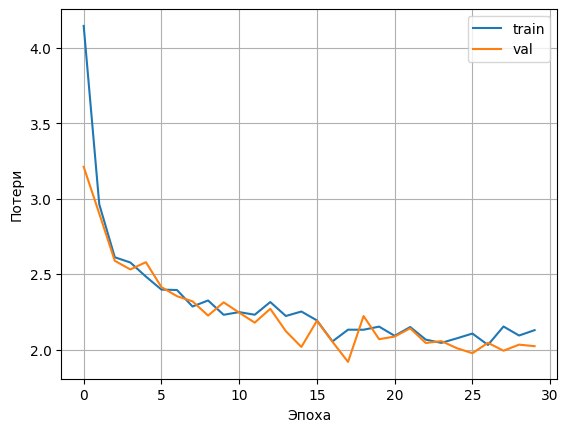

Тестирование модели...
Сгенерированное описание: a man is cutting a

Оценка качества модели на тесте...


Оценка:   0%|          | 0/296 [00:00<?, ?it/s]

BLEU-4: 0.1061
Визуализация предсказаний...


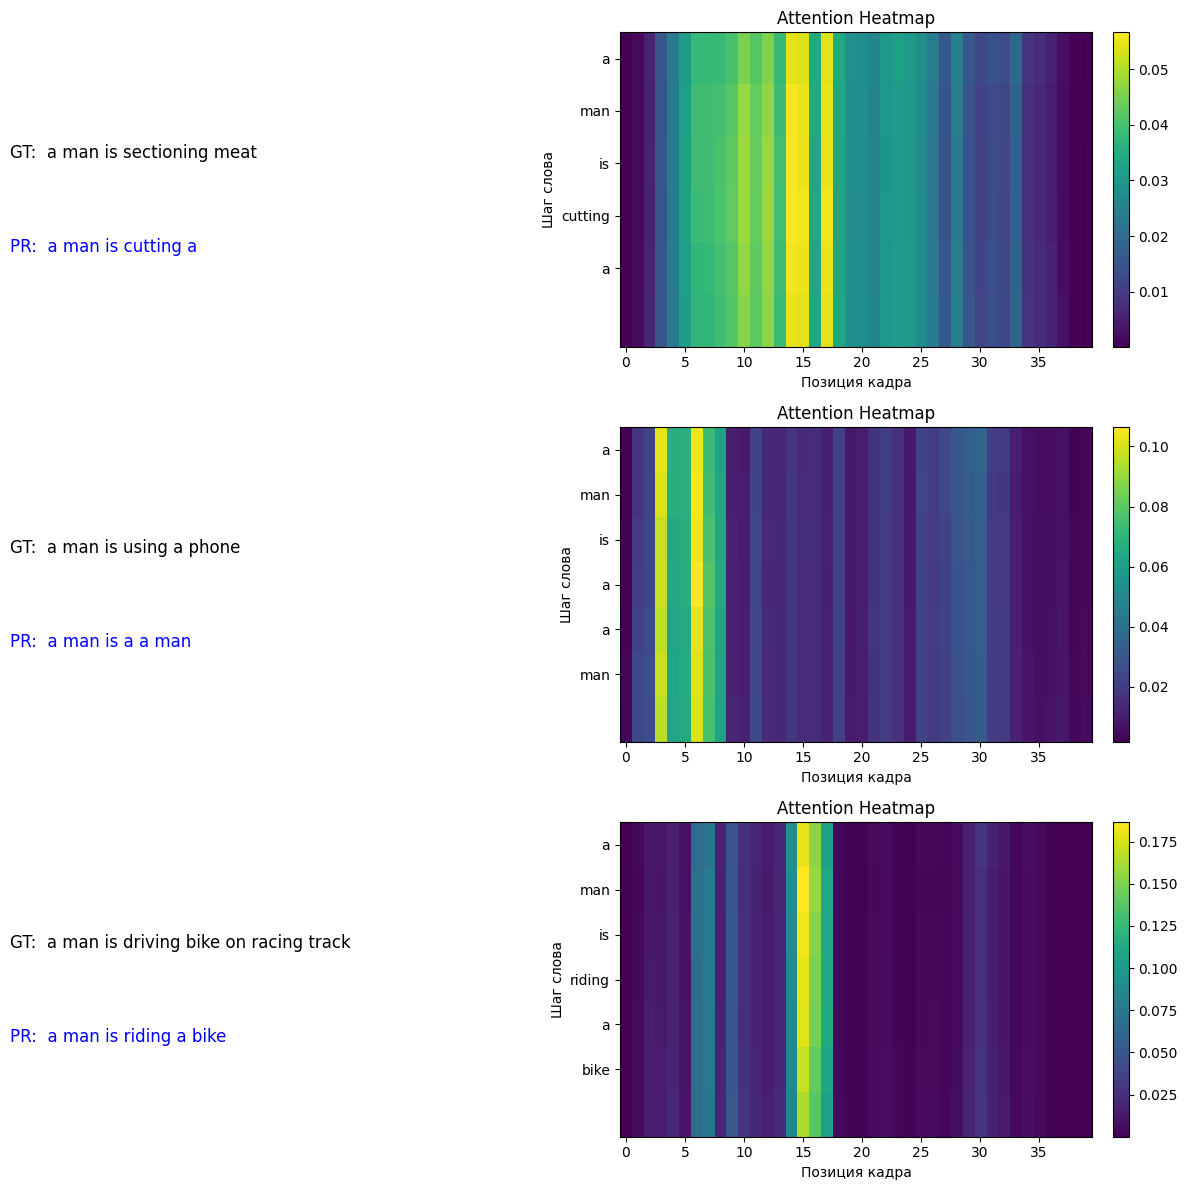

Анализ паттернов внимания на одном примере...


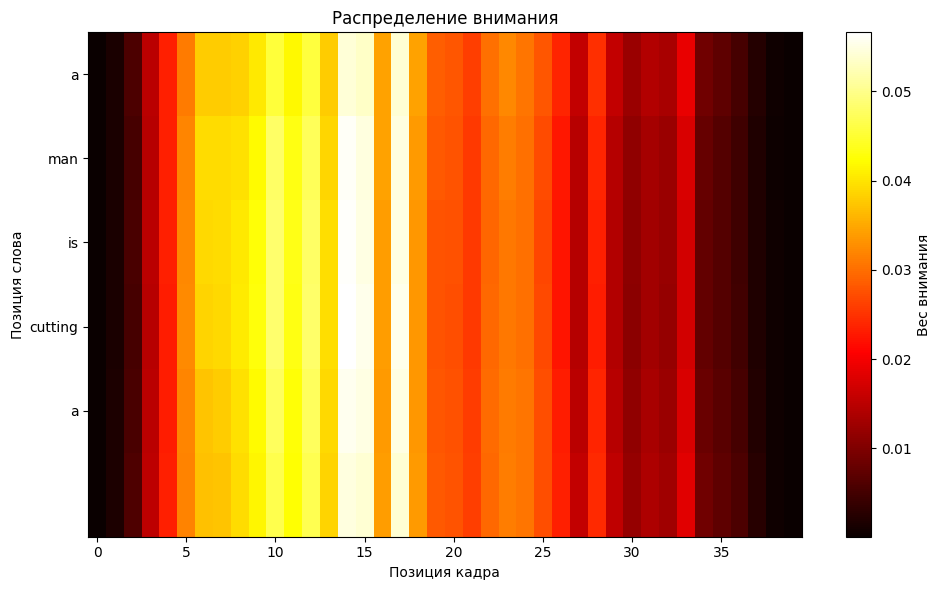

Соответствие слов и кадров:
  'a': кадр 14, вес = 0.0542
  'man': кадр 14, вес = 0.0561
  'is': кадр 14, вес = 0.0564
  'cutting': кадр 14, вес = 0.0566
  'a': кадр 14, вес = 0.0557

Самые важные кадры:
  Кадр 14: общий вес = 0.3337
  Кадр 17: общий вес = 0.3282
  Кадр 15: общий вес = 0.3274
  Кадр 10: общий вес = 0.2841
  Кадр 12: общий вес = 0.2833
Предупреждение: Несоответствие количества слов и весов внимания


In [12]:
if __name__ == "__main__":
    main()